In [49]:
import statsmodels.api as sm
import statsmodels.stats.sandwich_covariance as sw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [50]:
OK = pd.read_excel(
    "data/OK.xlsx",
    sheet_name=0,
    engine="openpyxl"
)

OK["Date"] = pd.to_datetime(OK["Date"])
OK = OK.set_index("Date").sort_index()

OK.head()

,Close
Date,
2020-01-02,54.99
2020-01-03,54.69
2020-01-06,54.67
2020-01-07,54.25
2020-01-08,54.35


In [51]:
SP500 = pd.read_excel(
    "data/SP500.xlsx",
    sheet_name=0,
    engine="openpyxl"
)

SP500["Date"] = pd.to_datetime(SP500["Date"])
SP500 = SP500.set_index("Date").sort_index()

SP500.head()

,Close
Date,
2020-01-02,3257.85
2020-01-03,3234.85
2020-01-06,3246.28
2020-01-07,3237.18
2020-01-08,3253.05


In [52]:
GCF = pd.read_excel(
    "data/GCF.xlsx",
    sheet_name=0,
    engine="openpyxl"
)

GCF["Date"] = pd.to_datetime(GCF["Date"])
GCF = GCF.set_index("Date").sort_index()

GCF.head()

,Close
Date,
2020-01-02,1524.5
2020-01-03,1549.2
2020-01-06,1566.2
2020-01-07,1571.8
2020-01-08,1557.4


In [53]:
CRSP = pd.read_excel(
    "data/CRSP.xlsx",
    sheet_name=0,
    engine="openpyxl"
)

CRSP["Date"] = pd.to_datetime(CRSP["Date"])
CRSP = CRSP.set_index("Date").sort_index()

CRSP.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2020-01-02,0.86,-0.88,-0.34,0.006
2020-01-03,-0.67,0.38,0.01,0.006
2020-01-06,0.36,-0.07,-0.55,0.006
2020-01-07,-0.19,-0.01,-0.26,0.006
2020-01-08,0.47,-0.07,-0.64,0.006


## Calculate daily rate of return

In [54]:
# r(t+1) = ln[P(t+1) / P(t)]
OK["log_return"] = np.log(OK["Close"] / OK["Close"].shift(1))

# r(t+1) = [P(t+1) - P(t)] / P(t)
OK["arith_return"] = OK["Close"].pct_change()

OK.head()

,Close,log_return,arith_return
Date,,,
2020-01-02,54.99,NaN,NaN
2020-01-03,54.69,-0.005470,-0.005456
2020-01-06,54.67,-0.000366,-0.000366
2020-01-07,54.25,-0.007712,-0.007682
2020-01-08,54.35,0.001842,0.001843


In [55]:
# r(t+1) = ln[P(t+1) / P(t)]
SP500["log_return"] = np.log(SP500["Close"] / SP500["Close"].shift(1))

# r(t+1) = [P(t+1) - P(t)] / P(t)
SP500["arith_return"] = SP500["Close"].pct_change()

SP500.head()

,Close,log_return,arith_return
Date,,,
2020-01-02,3257.85,NaN,NaN
2020-01-03,3234.85,-0.007085,-0.007060
2020-01-06,3246.28,0.003527,0.003533
2020-01-07,3237.18,-0.002807,-0.002803
2020-01-08,3253.05,0.004890,0.004902


In [56]:
# r(t+1) = ln[P(t+1) / P(t)]
GCF["log_return"] = np.log(GCF["Close"] / GCF["Close"].shift(1))

# r(t+1) = [P(t+1) - P(t)] / P(t)
GCF["arith_return"] = GCF["Close"].pct_change()

GCF.head()

,Close,log_return,arith_return
Date,,,
2020-01-02,1524.5,NaN,NaN
2020-01-03,1549.2,0.016072,0.016202
2020-01-06,1566.2,0.010914,0.010973
2020-01-07,1571.8,0.003569,0.003576
2020-01-08,1557.4,-0.009204,-0.009161


## Stock data

In [57]:
# 选用对数收益率列并去掉 NaN
KO_ret = OK["log_return"].dropna()

# 计算统计量
stats = {
    "Name"       : "Coca-Cola",
    "Ticker"     : "KO",
    "Mean"       : KO_ret.mean(),
    "Median"     : KO_ret.median(),
    "Std Dev"    : KO_ret.std(ddof=1),   # 样本标准差
    "Min"        : KO_ret.min(),
    "Max"        : KO_ret.max(),
    "Skewness"   : KO_ret.skew(),
    "Kurtosis"   : KO_ret.kurt(),
    "Start Date" : KO_ret.index.min().date(),
    "End Date"   : KO_ret.index.max().date()
}


summary = pd.DataFrame(stats, index=["Value"]).T
print(summary.to_string())

                 Value
Name         Coca-Cola
Ticker              KO
Mean          0.000193
Median        0.000958
Std Dev       0.015624
Min          -0.101728
Max           0.062783
Skewness     -0.841427
Kurtosis      6.966093
Start Date  2020-01-03
End Date    2022-12-30


In [58]:
# 选用对数收益率列并去掉 NaN
SP500_ret = SP500["log_return"].dropna()

# 计算统计量
stats = {
    "Name"       : "S&P 500",
    "Ticker"     : "^GSPC",
    "Mean"       : SP500_ret.mean(),
    "Median"     : SP500_ret.median(),
    "Std Dev"    : SP500_ret.std(ddof=1),   # 样本标准差
    "Min"        : SP500_ret.min(),
    "Max"        : SP500_ret.max(),
    "Skewness"   : SP500_ret.skew(),
    "Kurtosis"   : SP500_ret.kurt(),
    "Start Date" : SP500_ret.index.min().date(),
    "End Date"   : SP500_ret.index.max().date()
}

summary = pd.DataFrame(stats, index=["Value"]).T
print(summary.to_string())

                 Value
Name           S&P 500
Ticker           ^GSPC
Mean          0.000218
Median        0.000881
Std Dev       0.016118
Min          -0.127652
Max           0.089683
Skewness     -0.745384
Kurtosis     10.943675
Start Date  2020-01-03
End Date    2022-12-30


## Separate the data

In [59]:
# --- 函数：计算描述性统计 -------------------------------------------------
def get_stats(series):
    return {
        "Mean"     : series.mean(),
        "Median"   : series.median(),
        "Std Dev"  : series.std(ddof=1),
        "Min"      : series.min(),
        "Max"      : series.max(),
        "Skewness" : series.skew(),
        "Kurtosis" : series.kurt()
    }

# --- 1. 按时间切片 --------------------------------------------------------
train_OK = OK.loc["2020":"2021", "log_return"].dropna()   # 前两年
test_OK  = OK.loc["2022", "log_return"].dropna() # 最后一年

# --- 2. 生成统计表 ---------------------------------------------------------
stats_train_OK = pd.DataFrame(get_stats(train_OK), index=["2020-2021"]).T
stats_test_OK  = pd.DataFrame(get_stats(test_OK),  index=["2022"]).T

print("\n===== KO-train (2020-2021) =====")
print(stats_train_OK.to_string())

print("\n===== KO-test (2022) =====")
print(stats_test_OK.to_string())


===== KO-train (2020-2021) =====
          2020-2021
Mean       0.000147
Median     0.000751
Std Dev    0.016984
Min       -0.101728
Max        0.062783
Skewness  -0.815080
Kurtosis   6.624366

===== KO-test (2022) =====
              2022
Mean      0.000286
Median    0.001399
Std Dev   0.012482
Min      -0.072169
Max       0.037942
Skewness -0.835994
Kurtosis  4.678076


In [60]:
# --- 1. 按时间切片 --------------------------------------------------------
train_SP500 = SP500.loc["2020":"2021", "log_return"].dropna()   # 前两年
test_SP500  = SP500.loc["2022", "log_return"].dropna() # 最后一年

# --- 2. 生成统计表 ---------------------------------------------------------
stats_train_SP500 = pd.DataFrame(get_stats(train_SP500), index=["2020-2021"]).T
stats_test_SP500  = pd.DataFrame(get_stats(test_SP500),  index=["2022"]).T

print("\n===== SP500-train (2020-2021) =====")
print(stats_train_SP500.to_string())

print("\n===== SP500-test (2022) =====")
print(stats_test_SP500.to_string())


===== SP500-train (2020-2021) =====
          2020-2021
Mean       0.000755
Median     0.001658
Std Dev    0.016527
Min       -0.127652
Max        0.089683
Skewness  -1.049193
Kurtosis  14.893687

===== SP500-test (2022) =====
              2022
Mean     -0.000861
Median   -0.001593
Std Dev   0.015239
Min      -0.044199
Max       0.053953
Skewness -0.008660
Kurtosis  0.367144


In [61]:
# --- 按时间切片 --------------------------------------------------------
train_GCF = GCF.loc["2020":"2021", "log_return"].dropna()   # 前两年
test_GCF  = GCF.loc["2022", "log_return"].dropna() # 最后一年


CRSP["Mkt_Total"] = CRSP["Mkt-RF"] + CRSP["RF"]
train_CRSP = CRSP.loc["2020":"2021", "Mkt_Total"].dropna()   # 前两年
test_CRSP  = CRSP.loc["2022", "Mkt_Total"].dropna()          # 最后一年

## OLS & Newey-West

### OK

In [62]:
# X: intercept + time trend based on the DatetimeIndex                            
t_train = train_OK.index.map(pd.Timestamp.toordinal).to_numpy() # convert dates → integers
X_train = sm.add_constant(t_train) # add intercept

y_train = train_OK.values

# OLS
model = sm.OLS(y_train, X_train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7580
Date:                Tue, 17 Jun 2025   Prob (F-statistic):              0.384
Time:                        23:24:14   Log-Likelihood:                 1339.8
No. Observations:                 504   AIC:                            -2676.
Df Residuals:                     502   BIC:                            -2667.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3085      2.652     -0.871      0.3

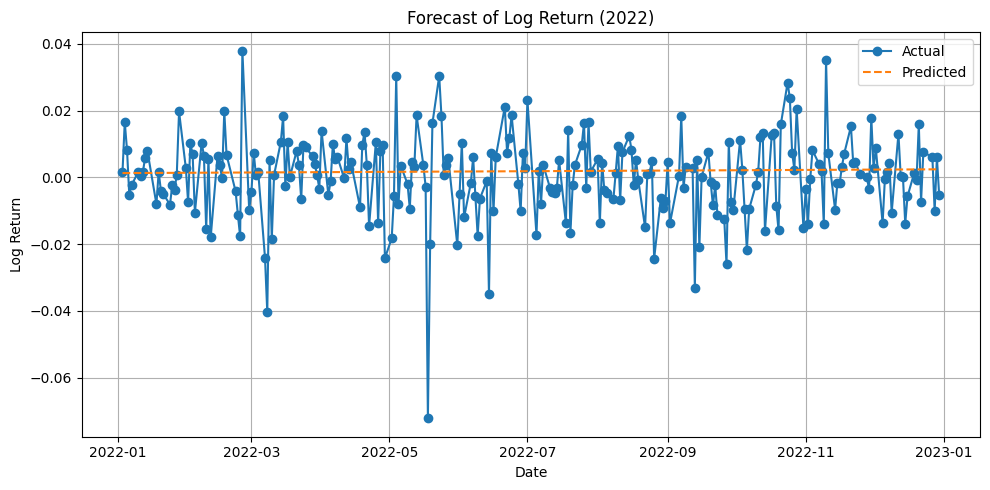

In [63]:
# --- 第四步：测试集的解释变量 ---
t_test = test_OK.index.map(pd.Timestamp.toordinal).to_numpy()
X_test = sm.add_constant(t_test)

# --- 第五步：模型预测 ---
y_pred = model.predict(X_test)

# --- 第六步：测试集的实际值 ---
y_test = test_OK.values

# --- 第七步：可视化 ---
plt.figure(figsize=(10, 5))
plt.plot(test_OK.index, y_test, label="Actual", marker='o')
plt.plot(test_OK.index, y_pred, label="Predicted", linestyle='--')
plt.title("Forecast of Log Return (2022)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
hac_cov = sw.cov_hac(model, 1)

s = model.get_robustcov_results(cov_type='HAC', maxlags=1)
print(s.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5620
Date:                Tue, 17 Jun 2025   Prob (F-statistic):              0.454
Time:                        23:24:14   Log-Likelihood:                 1339.8
No. Observations:                 504   AIC:                            -2676.
Df Residuals:                     502   BIC:                            -2667.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3085      3.080     -0.750      0.4

### Stock returns vs intercept, benchmark returns, and X2 returns

In [65]:
train1 = pd.concat([
    train_OK.rename("KO_logRet"),
    train_SP500.rename("SP500_logRet"),
    train_GCF.rename("Gold_logRet")
], axis=1)

y1 = train1["KO_logRet"]
X1 = train1[["SP500_logRet", "Gold_logRet"]]

X1c = (sm.add_constant(X1, has_constant='add')
          .rename(columns={"const": "Intercept"}))

# OLS
ols1 = sm.OLS(y1, X1c).fit()
print("=== OLS ===")
print(ols1.summary())

=== OLS ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     319.7
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           3.22e-90
Time:                        23:24:14   Log-Likelihood:                 1546.7
No. Observations:                 504   AIC:                            -3087.
Df Residuals:                     501   BIC:                            -3075.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0004      0.001  

In [66]:
# Newey-West (lag = 1)
hac1 = ols1.get_robustcov_results(cov_type="HAC", maxlags=1)
print("\n=== Newey-West (lag = 1) ===")
print(hac1.summary())


=== Newey-West (lag = 1) ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     101.4
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           1.09e-37
Time:                        23:24:14   Log-Likelihood:                 1546.7
No. Observations:                 504   AIC:                            -3087.
Df Residuals:                     501   BIC:                            -3075.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0

### Stock returns vs intercept, CRSP returns and X2 returns

In [67]:
train2 = pd.concat([
    train_OK.rename("KO_logRet"),
    train_CRSP.rename("CRSP_logRet"),
    train_GCF.rename("Gold_logRet")
], axis=1).dropna()

y2  = train2["KO_logRet"]
X2  = train2[["CRSP_logRet", "Gold_logRet"]]
X2c = (sm.add_constant(X2, has_constant='add')
          .rename(columns={"const": "Intercept"}))

ols2 = sm.OLS(y2, X2c).fit()
print("\n=== OLS ===")
print(ols2.summary())


=== OLS ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     269.0
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           4.51e-80
Time:                        23:24:14   Log-Likelihood:                 1523.2
No. Observations:                 504   AIC:                            -3040.
Df Residuals:                     501   BIC:                            -3028.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0006      0.001    

In [68]:
hac2 = ols2.get_robustcov_results(cov_type="HAC", maxlags=1)
print("\n=== Newey-West (lag = 1) ===")
print(hac2.summary())


=== Newey-West (lag = 1) ===
                            OLS Regression Results                            
Dep. Variable:              KO_logRet   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     117.3
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           1.60e-42
Time:                        23:24:14   Log-Likelihood:                 1523.2
No. Observations:                 504   AIC:                            -3040.
Df Residuals:                     501   BIC:                            -3028.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.00